In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from colicoords import SynthCell, SynthCellList, CellPlot, CellListPlot, load, align_cells

## Coordinate transformations

In this example we will look at how to transform a pair of `(x, y)` carthesian image coordinates to cellular coordinates and vice versa. 

Here we use `SynthCell`, which is a subclass of `Cell`, and it allows the user to generate cell objects for testing and simulation purposes.  The cell object is initialized by specifing the length, radius and curvature (units are pixels):

In [2]:
cell_1 = SynthCell(50, 8, 0.005)
cp_1 = CellPlot(cell_1)

Next is to define two points to test the coordinate transformation, we have chosen one point along the midsection of the cell (blue) and one at the pole (green). 

In [3]:
p1 = (20, 3)
p2 = (70, 25)

<IPython.core.display.Javascript object>


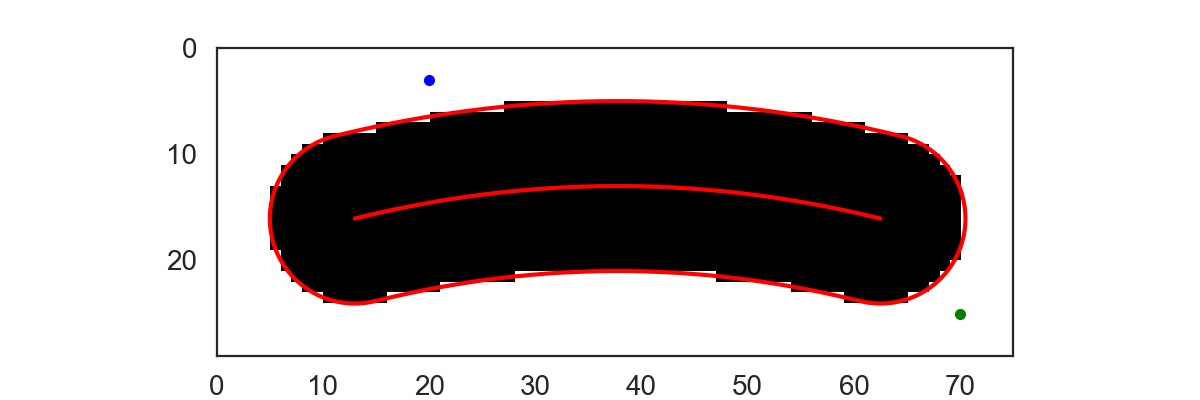

In [4]:
plt.figure(figsize=(6,2))
cp_1.imshow('binary')
cp_1.plot_outline()
cp_1.plot_midline()
plt.plot(*p1, 'b.')
plt.plot(*p2, 'g.')

To transform the coordinates to cell coordiantes:

In [5]:
cell_1.coords.transform(*p1)

(8.981099992419189, 11.41476377161665, 0.0)

The returned values are $l_c$, $r_c$ and $\phi$, respectively. The first coordinate ($l_c$) coordinate of `p1` along the length of the cell. The second coordinate ($r_c$) is the distance from the midline to the point `p1`. The third coordinate ($\phi$) describes the angle from a line perpendicular to the cell's mideline. This is given in degrees and is defined to be 0 a the top, running from 0 to 180 along the right pole, 180 below the midline, and from 180 back to 0 along the left pole.

We can check the result by tranforming the coordinates back using the same cell's coordinate system:

In [6]:
l, r, phi = cell_1.coords.transform(*p1)
cell_1.coords.rev_transform(l, r, phi, l_norm=False)

(19.99999999999999, 3.0000000000000018)

We can see we get the original coordinates back (within a factor of $~10^{-16}$ of a pixel, typically on the order of yoctometers)). The `l_norm` keyword arguments indicates that the input $l_c$ coordinate is in absolute units rather than a fraction of the total length of the cell.

The second point transforms in a similar fashion:

In [7]:
cell_1.coords.transform(*p2)

(50.000000000000014, 11.667776499545694, 126.09313884379844)

In [8]:
l, r, phi = cell_1.coords.transform(*p2)
cell_1.coords.rev_transform(l, r, phi, l_norm=False)

(70.0, 24.999999999999996)

We can also transform the points back onto another cell. For this we'll generate a differently shaped cell:

In [9]:
cell_2 = SynthCell(30, 7, -0.0025)
cp_2 = CellPlot(cell_2)

The cartesian coordinates are then transformed to cell coordinates using the coordinate system of cell 1, and then back transformed using the coordinate system of cell 2. Note that the input length coordinate is now input as a fraction of the whole cell length. 

In [10]:
l, r, phi = cell_1.coords.transform(*p1)
p1_t = cell_2.coords.rev_transform(l/cell_1.length, r, phi)

l, r, phi = cell_1.coords.transform(*p2)
p2_t = cell_2.coords.rev_transform(l/cell_1.length, r, phi)

We can use these result to plot the points `p1` and `p2` as if they 

<IPython.core.display.Javascript object>


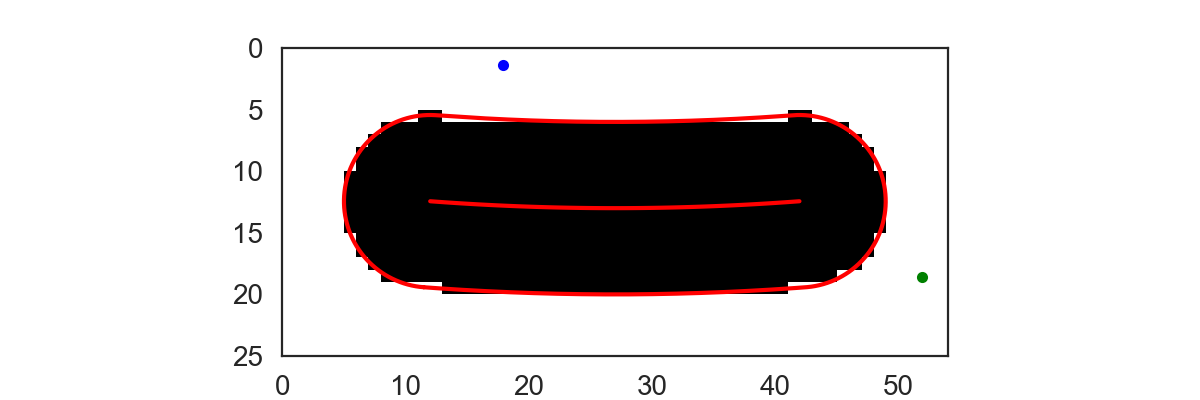

In [11]:
plt.figure(figsize=(6,2))
cp_2.imshow('binary')
cp_2.plot_outline()
cp_2.plot_midline()
plt.plot(*p1_t, 'b.')
plt.plot(*p2_t, 'g.')

## Cell Alignment

In this second part of the tutorial we will transform first the fluorescence channel and second storm localizations from many differently shaped cells to one model cell. We will load a set of 50 cells with previously generated fluorescence images and storm localizations.

In [12]:
cell_list = load('data/03_synthetic_cells.hdf5')

To explore this data set the radial distribution of the fluorescence and storm data elements are plotted, as well as a histgram of both length and radius. This particular dataset features a fluorecence channel with a signal mostly from the cell's membrane as well a set of STORM-type localizations homogenously distributed on the membrane.

<IPython.core.display.Javascript object>


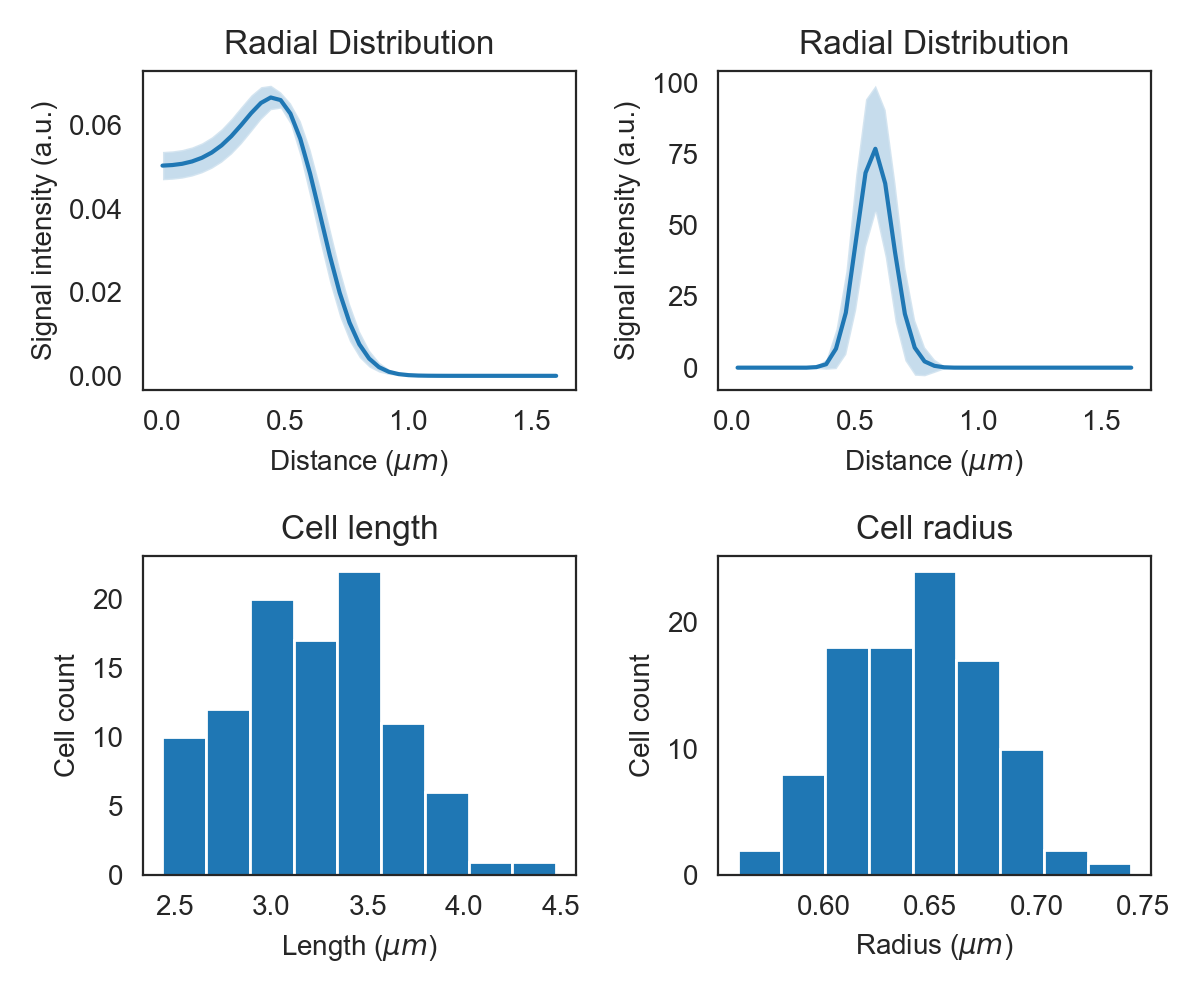

In [13]:
clp = CellListPlot(cell_list)
fig, axes = plt.subplots(2, 2, figsize=(6, 5))
clp.plot_r_dist(data_name='fluorescence', ax=axes[0, 0])
clp.plot_r_dist(data_name='storm', method='box', ax=axes[0, 1])
clp.hist_property('length', ax=axes[1, 0])
clp.hist_property('radius', ax=axes[1, 1])
plt.tight_layout()

We can look at one individual cell for some more detail. As can been seen from the image the cells in this dataset also have a bit of curvature. We can quantify this by looking at the second-degree coefficient.

<IPython.core.display.Javascript object>


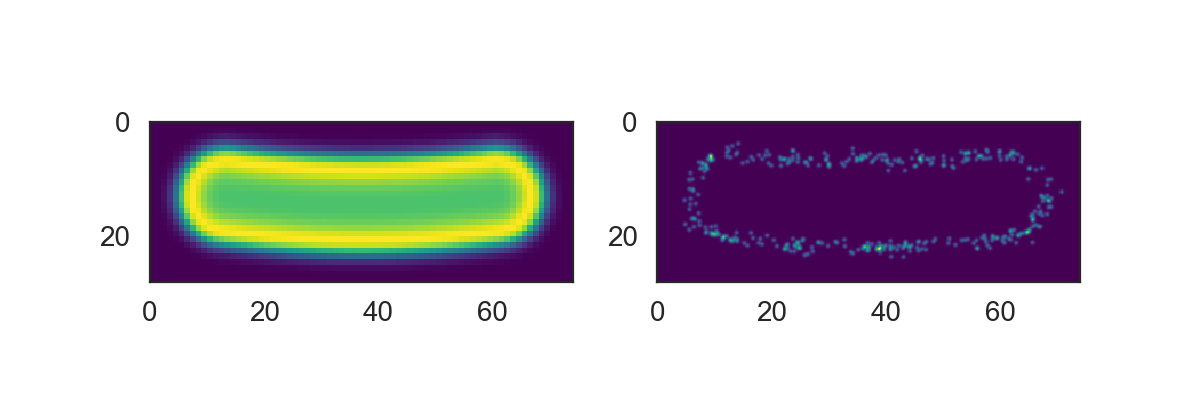

In [14]:
cp = CellPlot(cell_list[0])
fig, axes = plt.subplots(1, 2, figsize=(6, 2))
cp.imshow('fluorescence', ax=axes[0])
cp.plot_storm(method='gauss', ax=axes[1])

<IPython.core.display.Javascript object>


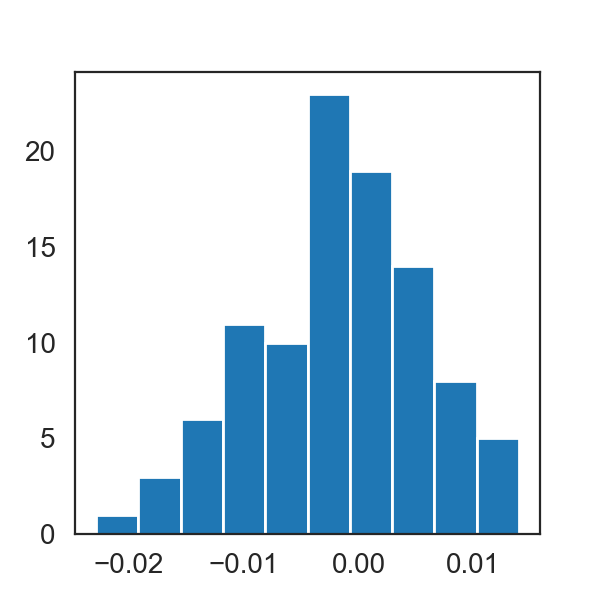

In [15]:
plt.figure(figsize=(3,3))
h = plt.hist([c.coords.a2 for c in cell_list])

We have take the data in this dataset and map it onto one model cell with dimensions of our choosing. Here, we generate a cell with length and radius 40 and 8 pixels (2 $\mu$m and 640 nm) respectively. The curvature is set to (near) zero. The length and radius of the model cell are chosen to reflect the average values of the cells in the dataset, however, this is not a requirement.

In [16]:
cell_list.length.mean(), cell_list.radius.mean()

(40.238266004516824, 8.044296835021418)

In [17]:
model_cell = SynthCell(40, 8, 1e-5)

<IPython.core.display.Javascript object>


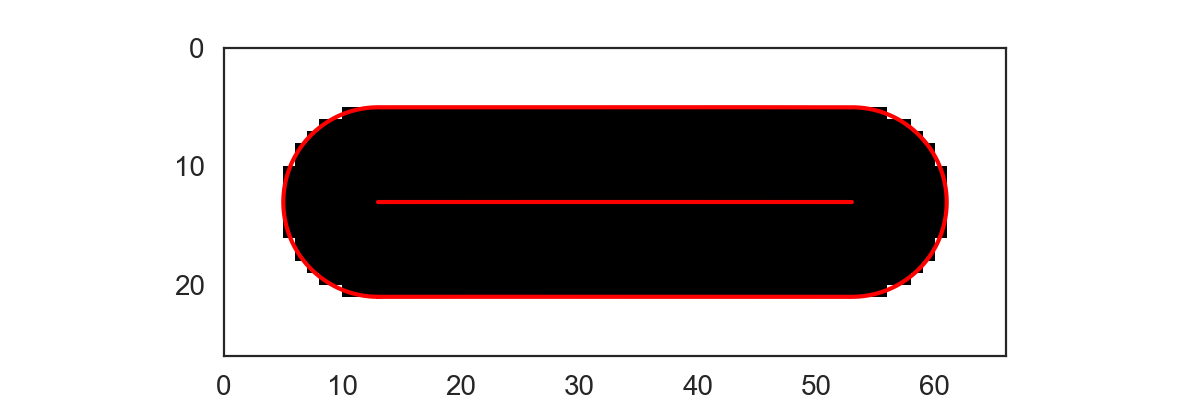

In [18]:
cp_m = CellPlot(model_cell)
plt.figure(figsize=(6,2))
cp_m.imshow('binary')
cp_m.plot_outline()
cp_m.plot_midline()

To illustrate the process, we will first map the position of all pixels in on cell of the dataset to our model cell. We use the attributes `Cell.coords.lc`, `Cell.coords.rc`, `Cell.coords.phi` which are contain the cell coordinates for all pixels in the image. The length coordinates are again divided by the cell's length to normalize it.

In [19]:
cell_0 = cell_list[0]
x, y = model_cell.coords.rev_transform(cell_0.coords.lc / cell_0.length, cell_0.coords.rc, cell_0.coords.phi)

<IPython.core.display.Javascript object>


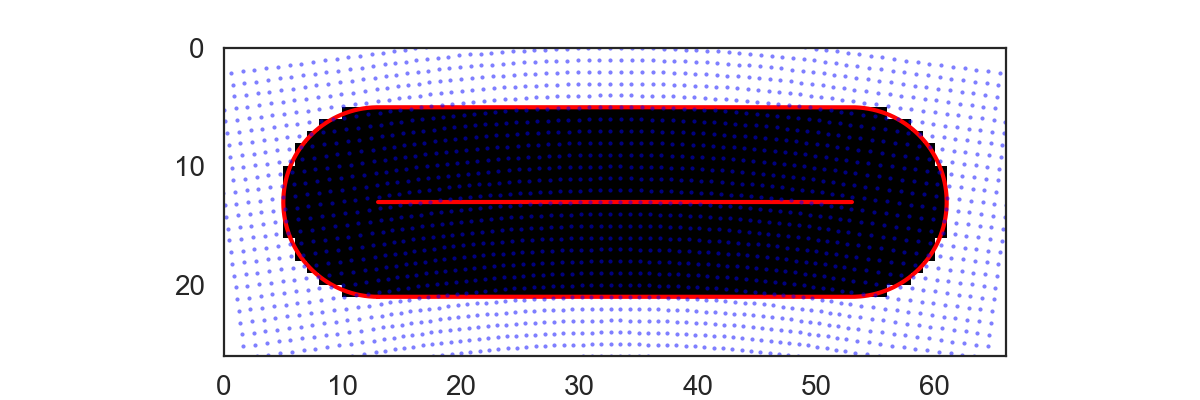

In [20]:
cp_m = CellPlot(model_cell)
plt.figure(figsize=(6,2))
cp_m.imshow('binary')
cp_m.plot_outline()
cp_m.plot_midline()
plt.plot(x.flatten(), y.flatten(), 'b.', alpha=0.5, markersize=1)

The image above shows the coordinates of the pixels in the first cell of the dataset mapped to the model cell. The density of pixels at the poles remains the same but along the body of the cell the space is contracted to map the long curved cell onto the smaller model cell.

We can do the aligment for all cells in the set by calling `align_cells`. This will iterate though all cells and take the pixels in the specified data element and transform the coordinates. The datapoints `(x, y)` have a corresponding `z` value which is the measured fluorescence intensity at that pixel. To form the final image the point cloud is convoluted with a guassian averaging filter, where in this case the specified sigma is one pixel.

In [21]:
img = align_cells(model_cell, cell_list, 'fluorescence', r_norm=True, sigma=1)
model_cell.data.add_data(img, 'fluorescence', 'flu_aligned')

The returned image has the same dimensions as the binary image in the model cell. This means we can add it to the `Cell` object as a new data element. We add it by specifying its data class and give it a name. We can now plot it through `CellPlot`:

<IPython.core.display.Javascript object>


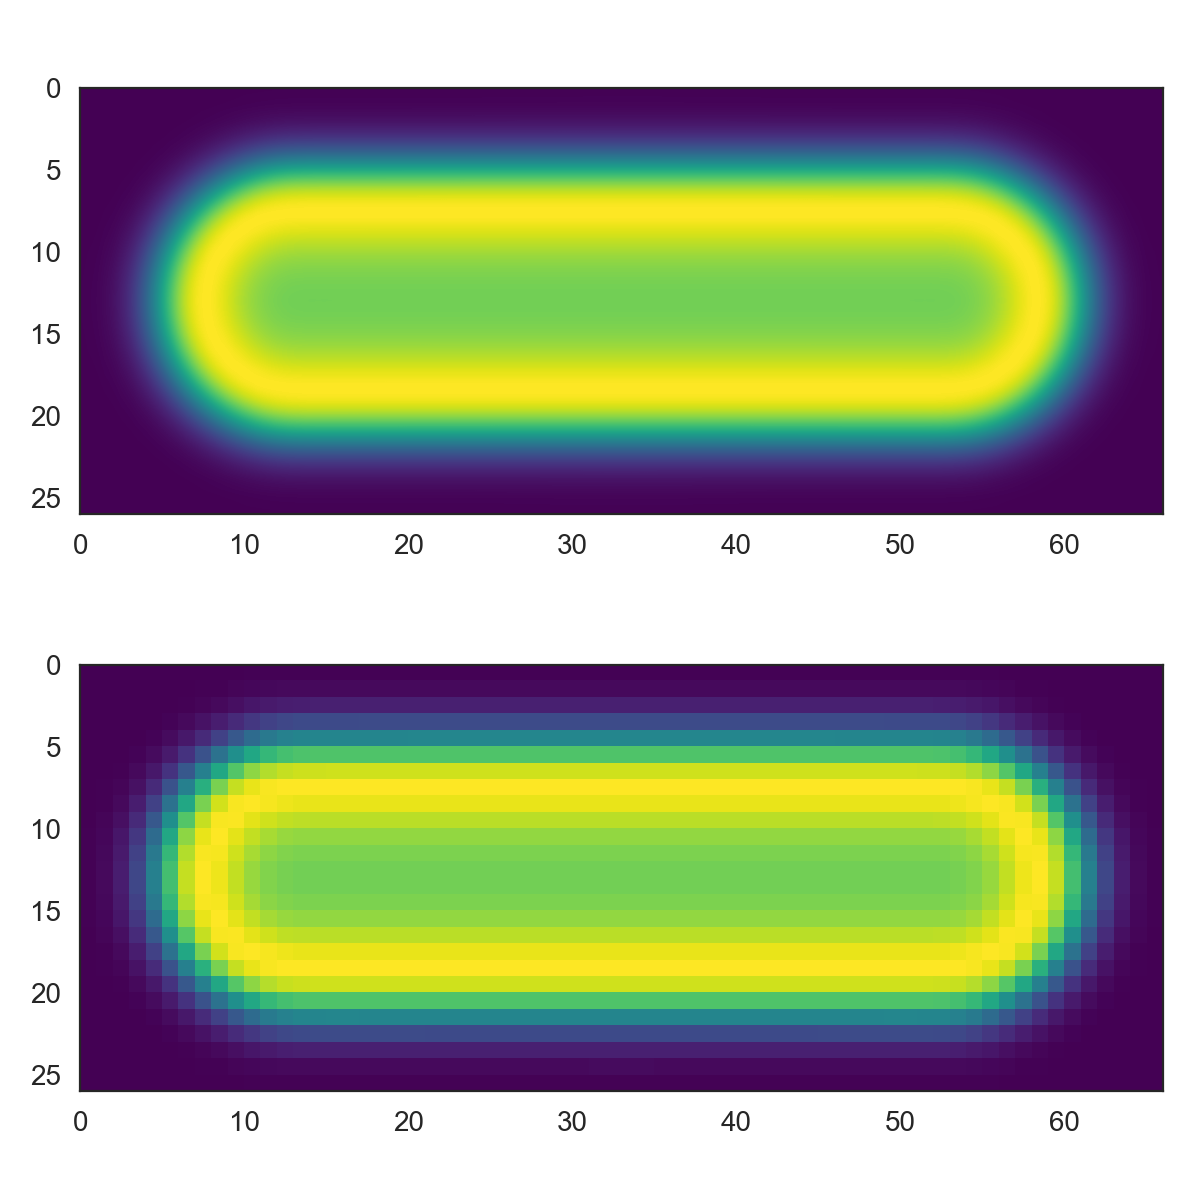

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(6,6))
cp_m = CellPlot(model_cell)
cp_m.imshow('flu_aligned', interpolation='spline16', ax=axes[0])
cp_m.imshow('flu_aligned', ax=axes[1])

plt.tight_layout()

The images above show the result of the alignment. We can repeat the process for the STORM localizations dataset. 

In [23]:
output = align_cells(model_cell, cell_list, 'storm')
model_cell.data.add_data(output, 'storm', 'storm_aligned')

Here the returned `output` is a `numpy` structured array with all localizations from all cells combined. This dataset can then be added to our model cell for plotting. By specifying `method=gauss` the STORM image is reconstructed by placing a gaussian on the output image with a `sigma` of 0.25 pixel. This is the default value and a different value can be specified, see for more details the docstring or API docs. 

In [ ]:
plt.figure(figsize=(6,3))
cp_m = CellPlot(model_cell)
cp_m.plot_storm(method='gauss', upscale=5, cmap='viridis')
plt.tight_layout()

<IPython.core.display.Javascript object>